In [1]:
import psycopg2
import pandas as pd
import pandas.io.sql as psql
import json
import re
import seaborn as sns
import scipy.stats as ss
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def get_boolean_status(value):
    if value == 'pending':
        return 0
    elif value == 'paid': 
        return 1

In [3]:
def format_number_string(number_string):
    return number_string.replace('.', '').replace(',', '.')

def number_string_to_float(number_string):
    return float(format_number_string(number_string))

def mean(first_value, second_value):
    return (first_value + second_value) / 2

def is_valid_parameter(value):
    if value == 'null' or value is None:
        return False
    else:
        return True

def ph3aIncome_mean_or_none(value):
    mean_value = 0
    if is_valid_parameter(value):
        json_value = json.loads(value)
        lower_bound = number_string_to_float(json_value["Of"])
        upper_bound = number_string_to_float(json_value["To"])
        mean_value = mean(lower_bound, upper_bound)
    else:   
        mean_value = None
    return mean_value

def installment_value_over_ph3aIncome_mean_or_none(installment_value, ph3aIncome_mean):
    return ratio(installment_value, ph3aIncome_mean)

In [4]:
def is_not_float(object):
    return not isinstance(object, float)

def ratio(numerator, denominator):
    if is_not_float(numerator):
        numerator = number_string_to_float(numerator)
    if is_not_float(denominator):
        denominator = number_string_to_float(denominator)
    if denominator == 0:
        return None
    return numerator / denominator

In [5]:
def get_serasa_categories(dataframe):
#     values = dataframe['serasaIncome'].unique().tolist()
#     values = [incom for incom in values if incom is not None]
#     values.sort()
    column = dataframe['serasaIncome']
#     cat_type = CategoricalDtype([-1, 0, 1, 2, 3, 4, 5, 6], ordered = True)
#     column = column.astype(cat_type)
    column = column.astype('category')
    column = column.cat.codes
    return column

def get_category_column(dataframe, column_name):
    column = dataframe[column_name]
    column = column.astype('category')
    column = column.cat.codes
    return column



In [6]:
def get_due_date_as_date(dataframe):
    column = dataframe['installmentDueDate']
    column = column.astype('datetime64[ns, UTC]')
    return column
    

In [7]:
def get_feature_importances(dataframe, target):
    model = ExtraTreesClassifier(max_depth = 5)
    model.fit(dataframe, target)
    print(model.feature_importances)
    #plot graph of feature importances for better visualization
    return pd.Series(model.feature_importances_, index=dataframe.columns) #use inbuilt class feature_importances of tree based classifiers

def plot_feature_importances(feature_importances, title):
    feat_importances.nlargest(10).plot(kind='barh')
    plt.title(title)
    plt.show()

In [8]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [9]:
connection = psycopg2.connect("host='salt.db.elephantsql.com' user='lyvmydeu' password='Euvx1U98D3_Uo3c8Uxipb-zlwcvvgfS0' port='5432' dbname='lyvmydeu'")

In [10]:
# Get database tables
cursor = connection.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
print (cursor.fetchall())


[('SequelizeMeta',), ('InstallmentOverviews',)]


In [11]:
dataframe = psql.read_sql('SELECT * FROM "InstallmentOverviews";', connection)

In [12]:
dataframe

id                                UserId installmentStatus  \
0    362  92d5a4b9-ab4f-48f3-b7a1-dfd81fedf710           pending   
1    363  9e35210a-e9b8-4428-b3d1-1c45958d1adf           pending   
2    364  f1b46e91-a94b-4f91-a267-1c25891f9827           pending   
3    365  c162990c-91a3-4d7b-be82-cbdd19620337           pending   
4    366  b0cd0911-4a19-49b2-9457-d02caec5031d           pending   
5    367  36939d14-0615-43ea-b435-55f6f3a371ef           pending   
6    368  ac88fa96-21dd-49a2-b41e-e29e4231ddb2           pending   
7    369  ca4d1018-e648-4bfc-ac99-f97b9a6ec0e6              paid   
8    370  dd2065eb-209f-413c-8dfe-20894b97a168           pending   
9    371  c29700e7-6a07-4a12-8515-68237c6cf2a7           pending   
10   372  0e419530-e463-4a98-b921-bdfbb252c785              paid   
11   373  40d2350c-de4c-4a04-ae7a-348d0e3b70d5           pending   
12   374  76fc7db5-347b-49a4-bcc1-600672c57ca0           pending   
13   375  e84777c7-0c25-48d8-9119-9e4b9550d2f8           pending   
14   376  b5a3dc0b-8418-49ec-a229-a8121ae4f2dc              paid   
15   377  6b418184-3117-44a6-b041-4283b60391dd           pending   
16   378  f83059d4-df4c-4d3a-ada1-da72a44eef99              paid   
17   379  4f3e6c27-0f7f-4e59-864a-03ce2e5609db           pending   
18   380  d3a497e6-7f98-4eec-be7c-78b006d96b62           pending   
19   381  5902f6cf-3f31-48ff-9505-d1e282c1365b           pending   
20   382  739bba9a-864e-46d6-8756-477e7dcdedb4              paid   
21   383  bfed9e55-6b89-48fe-967a-8b9b538e962a           pending   
22   384  6ee6cc0d-4640-4706-a8ed-6ce92c72ce9a           pending   
23   385  04d3777e-eaa6-4ad7-b037-f0a8d965d4fc           pending   
24   386  ba4bdcaa-af0b-4064-a970-ffd75b7b8e31              paid   
25   387  04f0762d-214a-4f76-86d9-9cefb9926183              paid   
26   388  2bf8b361-a162-4d7d-9e71-fb240cc9f813              paid   
27   389  3d10a0b9-fbfa-4052-8e27-494413c442b7           pending   
28   390  90ac2f80-bc0f-49ef-a882-62fe92d3ccf1           pending   
29   391  deb48d16-273b-4fbb-83b1-eaca95ecd0be           pending   
..   ...                                   ...               ...   
71   433  c02f7b72-5d1b-4541-8521-7470fd9c254c              paid   
72   434  8fd19ebf-5051-47dd-90f7-189a2e0c5b8a              paid   
73   435  7fe7de18-e80f-4d73-8685-20ff8a2a88ec           pending   
74   436  22ed98d5-8b35-4ad0-8244-fa7b881fdf54              paid   
75   437  8bbbb30b-fe93-42e7-9031-46b4b34b1d0c              paid   
76   438  fadaa37c-e6e1-4f26-8c64-d1797ed7bf15              paid   
77   439  6d62e9c0-1511-480a-8db3-49df0f10ad0e              paid   
78   440  f7c963f2-e8cd-408b-83c2-1bb4a8fc3dcb              paid   
79   441  d686f15f-cfad-456b-8848-ac910c1ee789              paid   
80   442  1ef26c3f-6371-4126-8d13-be1528a55b15              paid   
81   443  8a279f92-ae74-4e9f-a913-f64b7dd03698              paid   
82   444  04230674-1566-4d2e-ad7b-f934ce2e181f              paid   
83   445  591499e0-ef34-4712-a3c2-30ddf22fd4e6              paid   
84   446  dd9f7435-5886-457a-8f5f-dce881c8646a              paid   
85   447  d6115cfc-e6c9-4877-9f95-51f601c8bcf2              paid   
86   448  7c7168ea-a9b7-476a-9287-04b87707e03d              paid   
87   449  16999f89-3a49-4aae-b855-e3ee913a35fa              paid   
88   450  28a8b0d4-b8c6-4f87-9576-3ed1cbe26c2d              paid   
89   451  6d89a1bb-4931-4281-94af-fadd8f8c2f69              paid   
90   452  b6c4d931-b01b-4a2b-a693-69b5d4f7b524              paid   
91   453  aea967f2-2c24-4722-b94e-f4ac58cea4b9              paid   
92   454  39c5d7f6-c370-4a1e-ad87-e6488286958a              paid   
93   455  c7c1e3d7-ba67-412f-b8c4-a63c712ffff0              paid   
94   456  68ae4c2b-5c89-4fab-b183-4ab6b9ddc9c2              paid   
95   457  79051a45-2a7d-4ad5-8d38-263f1e2bd38d              paid   
96   458  f865a3a3-3d26-4d45-b5ad-84d0d9616f40              paid   
97   459  b8203c28-540a-418e-922f-44c4662a5d57              pa

In [13]:
dataframe.shape

(101, 10)

In [14]:
dataframe.count()

id                      101
UserId                  101
installmentStatus       101
declaredMonthlyEarns    101
serasaIncome             17
ph3aIncome              101
installmentValue        101
installmentDueDate      101
createdAt               101
updatedAt               101
dtype: int64

In [15]:
installmentValueOverDeclaredMonthlyEarns = dataframe.apply(lambda value: ratio(value.installmentValue, value.declaredMonthlyEarns), axis=1)
dataframe.loc[:, 'installmentValueOverDeclaredMonthlyEarns'] = installmentValueOverDeclaredMonthlyEarns

In [16]:
dataframe['declaredMonthlyEarns'] = pd.to_numeric(dataframe['declaredMonthlyEarns'])
dataframe['installmentValue'] = pd.to_numeric(dataframe['installmentValue'])

In [17]:
# Convert serasaIncome to categories
dataframe.loc[:, 'serasaIncomeCategories'] = get_serasa_categories(dataframe)
serasa_income = dataframe[['serasaIncomeCategories', 'serasaIncome']]
# Check categories
serasa_income.head(20)

serasaIncomeCategories                       serasaIncome
0                        0                    Até R$ 1.000,00
1                        5  Mais de R$ 4.000,00 a R$ 5.000,00
2                        2  Mais de R$ 1.500,00 a R$ 2.000,00
3                        6                Mais de R$ 9.000,00
4                        3  Mais de R$ 2.500,00 a R$ 3.000,00
5                        4  Mais de R$ 3.000,00 a R$ 4.000,00
6                       -1                               None
7                       -1                               None
8                        3  Mais de R$ 2.500,00 a R$ 3.000,00
9                       -1                               None
10                      -1                               None
11                      -1                               None
12                       5  Mais de R$ 4.000,00 a R$ 5.000,00
13                       5  Mais de R$ 4.000,00 a R$ 5.000,00
14                      -1                               None
15                       0                    Até R$ 1.000,00
16                      -1                               None
17                      -1                               None
18                       1  Mais de R$ 1.000,00 a R$ 1.500,00
19                       2  Mais de R$ 1.500,00 a R$ 2.000,00

In [18]:
dataframe.loc[:, 'dayOfInstallmentDueDate'] = list(map(lambda value: value.day, dataframe['installmentDueDate']))
dataframe.loc[:, 'monthOfInstallmentDueDate'] = list(map(lambda value: value.month, dataframe['installmentDueDate']))
dataframe.loc[:, 'dayOfDueDateCategories'] = get_category_column(dataframe, 'dayOfInstallmentDueDate')
dataframe.loc[:, 'monthOfDueDateCategories'] = get_category_column(dataframe, 'monthOfInstallmentDueDate')

In [19]:
dataframe.loc[:, 'installmentDueDate'] = get_due_date_as_date(dataframe)

In [20]:
# Check installmentDueDate values
dataframe['dayOfInstallmentDueDate'].unique()

array([25, 10], dtype=int64)

In [21]:
averagePh3aIncome = list(map(lambda value: ph3aIncome_mean_or_none(value), dataframe['ph3aIncome']))
dataframe.loc[:, 'averagePh3aIncome'] = averagePh3aIncome
installmenValueOverAveragePh3aIncome = dataframe.apply(lambda value: ratio(value.installmentValue, value.averagePh3aIncome), axis=1)
dataframe.loc[:, 'installmenValueOverAveragePh3aIncome'] = installmenValueOverAveragePh3aIncome

In [22]:
# Convert installmentStatus to bool
dataframe.loc[:, 'booleanInstallmentStatus'] = list(map(lambda value: get_boolean_status(value), dataframe['installmentStatus']))

In [23]:
# Calculate mean of averagePh3aIncome and declareMonthlyEans
dataframe.loc[:, 'declaredMonthlyEarnsAndAveragePh3aMean'] = dataframe.apply(lambda value: ratio(value.declaredMonthlyEarns, value.averagePh3aIncome), axis=1)


In [24]:
# Calculate difference of averagePh3aIncome and declareMonthlyEans
dataframe.loc[:, 'declaredMonthlyEarnsAndAveragePh3aDifference'] = dataframe.apply(lambda value: value.declaredMonthlyEarns - value.averagePh3aIncome, axis=1)
dataframe.loc[:, 'declaredMonthlyEarnsAndAveragePh3aAbsoluteDifference'] = dataframe['declaredMonthlyEarnsAndAveragePh3aDifference'].abs()

In [25]:
dataframe.dtypes

id                                                                    int64
UserId                                                               object
installmentStatus                                                    object
declaredMonthlyEarns                                                float64
serasaIncome                                                         object
ph3aIncome                                                           object
installmentValue                                                    float64
installmentDueDate                                      datetime64[ns, UTC]
createdAt                                               datetime64[ns, UTC]
updatedAt                                               datetime64[ns, UTC]
installmentValueOverDeclaredMonthlyEarns                            float64
serasaIncomeCategories                                                 int8
dayOfInstallmentDueDate                                               int64
monthOfInsta

In [26]:
dataframe.corr()['booleanInstallmentStatus']

id                                                      0.637380
declaredMonthlyEarns                                    0.122286
installmentValue                                        0.200359
installmentValueOverDeclaredMonthlyEarns                0.061257
serasaIncomeCategories                                 -0.579120
dayOfInstallmentDueDate                                -0.230537
monthOfInstallmentDueDate                              -0.806417
dayOfDueDateCategories                                 -0.230537
monthOfDueDateCategories                               -0.806417
averagePh3aIncome                                      -0.099772
installmenValueOverAveragePh3aIncome                    0.196139
booleanInstallmentStatus                                1.000000
declaredMonthlyEarnsAndAveragePh3aMean                  0.171562
declaredMonthlyEarnsAndAveragePh3aDifference            0.219417
declaredMonthlyEarnsAndAveragePh3aAbsoluteDifference    0.029689
Name: booleanInstallmentS

In [27]:
# Get correlations of numeric variables
numeric_correlation_group = dataframe[['installmentValue', 'declaredMonthlyEarns', 'averagePh3aIncome', 'installmentValueOverDeclaredMonthlyEarns', 'installmenValueOverAveragePh3aIncome', 'declaredMonthlyEarnsAndAveragePh3aMean', 'declaredMonthlyEarnsAndAveragePh3aDifference', 'declaredMonthlyEarnsAndAveragePh3aAbsoluteDifference', 'booleanInstallmentStatus']]        
matrix = numeric_correlation_group.corr()['booleanInstallmentStatus'][:-1]
matrix

installmentValue                                        0.200359
declaredMonthlyEarns                                    0.122286
averagePh3aIncome                                      -0.099772
installmentValueOverDeclaredMonthlyEarns                0.061257
installmenValueOverAveragePh3aIncome                    0.196139
declaredMonthlyEarnsAndAveragePh3aMean                  0.171562
declaredMonthlyEarnsAndAveragePh3aDifference            0.219417
declaredMonthlyEarnsAndAveragePh3aAbsoluteDifference    0.029689
Name: booleanInstallmentStatus, dtype: float64

In [28]:
ph3aIncome_not_null = dataframe['ph3aIncome'] != 'null'

In [29]:
ph3aIncome_dataframe = dataframe[['averagePh3aIncome', 'installmenValueOverAveragePh3aIncome', 'declaredMonthlyEarnsAndAveragePh3aMean', 'declaredMonthlyEarnsAndAveragePh3aDifference', 'declaredMonthlyEarnsAndAveragePh3aAbsoluteDifference', 'booleanInstallmentStatus']]
ph3aIncome_not_null_dataframe = ph3aIncome_dataframe[ph3aIncome_not_null]
ph3aIncome_not_null_dataframe.count()

averagePh3aIncome                                       51
installmenValueOverAveragePh3aIncome                    49
declaredMonthlyEarnsAndAveragePh3aMean                  49
declaredMonthlyEarnsAndAveragePh3aDifference            51
declaredMonthlyEarnsAndAveragePh3aAbsoluteDifference    51
booleanInstallmentStatus                                51
dtype: int64

In [30]:
ph3aIncome_not_null_dataframe.corr()['booleanInstallmentStatus'][:-1]

averagePh3aIncome                                      -0.099772
installmenValueOverAveragePh3aIncome                    0.196139
declaredMonthlyEarnsAndAveragePh3aMean                  0.171562
declaredMonthlyEarnsAndAveragePh3aDifference            0.219417
declaredMonthlyEarnsAndAveragePh3aAbsoluteDifference    0.029689
Name: booleanInstallmentStatus, dtype: float64

In [31]:
pd.crosstab(dataframe['serasaIncomeCategories'], dataframe['booleanInstallmentStatus'])

booleanInstallmentStatus  0   1
serasaIncomeCategories         
-1                        9  75
 0                        5   0
 1                        2   0
 2                        2   0
 3                        2   0
 4                        1   1
 5                        3   0
 6                        1   0

Text(0.5, 0.98, 'Plot 1')

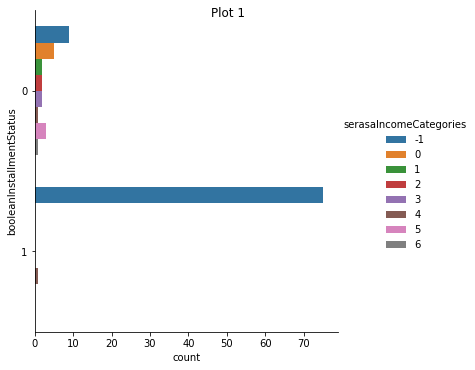

In [32]:
figure_1 = sns.catplot(y="booleanInstallmentStatus", hue="serasaIncomeCategories", kind="count", data=dataframe)
figure_1.fig.suptitle('Plot 1')

Text(0.5, 0.98, 'Plot 2')

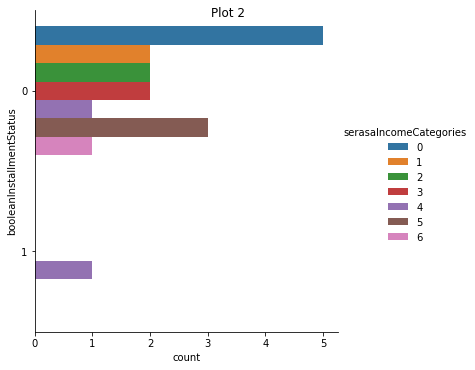

In [33]:
serasa_not_null = dataframe['serasaIncomeCategories'] != -1
serasa_not_null_dataframe = dataframe[serasa_not_null]
figure_2 = sns.catplot(y="booleanInstallmentStatus", hue="serasaIncomeCategories", kind="count", data=serasa_not_null_dataframe)
figure_2.fig.suptitle('Plot 2')

In [34]:
x = dataframe['serasaIncomeCategories'][serasa_not_null] 
y = dataframe['booleanInstallmentStatus']
cramers_v(x, y)

0.31622776601683794

In [35]:
serasa_not_null_dataframe.count()

id                                                      17
UserId                                                  17
installmentStatus                                       17
declaredMonthlyEarns                                    17
serasaIncome                                            17
ph3aIncome                                              17
installmentValue                                        17
installmentDueDate                                      17
createdAt                                               17
updatedAt                                               17
installmentValueOverDeclaredMonthlyEarns                15
serasaIncomeCategories                                  17
dayOfInstallmentDueDate                                 17
monthOfInstallmentDueDate                               17
dayOfDueDateCategories                                  17
monthOfDueDateCategories                                17
averagePh3aIncome                                       

In [36]:
pd.crosstab(dataframe['dayOfInstallmentDueDate'], dataframe['booleanInstallmentStatus'], margins = True)

booleanInstallmentStatus   0   1  All
dayOfInstallmentDueDate              
10                        11  53   64
25                        14  23   37
All                       25  76  101

Text(0.5, 0.98, 'Plot 3')

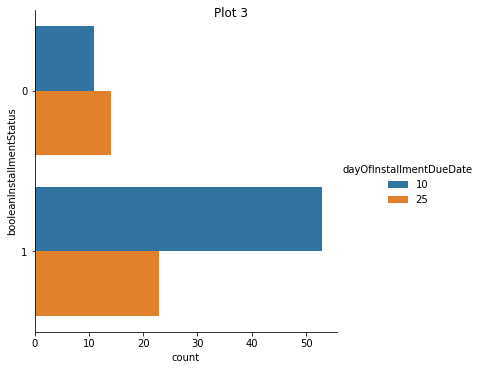

In [37]:
figure_3 = sns.catplot(y="booleanInstallmentStatus", hue="dayOfInstallmentDueDate", kind="count", data=dataframe)
figure_3.fig.suptitle('Plot 3')

In [38]:
x = dataframe['dayOfDueDateCategories']
y = dataframe['booleanInstallmentStatus']
cramers_v(x, y)

0.18184516272770587

In [39]:
pd.crosstab(dataframe['monthOfInstallmentDueDate'], dataframe['booleanInstallmentStatus'], margins = True)

booleanInstallmentStatus    0   1  All
monthOfInstallmentDueDate             
6                           0  12   12
7                           2  49   51
8                           0  15   15
9                          19   0   19
10                          4   0    4
All                        25  76  101

Text(0.5, 0.98, 'Plot 4')

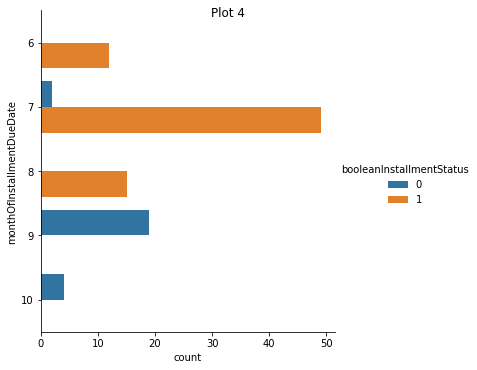

In [40]:
figure_4 = sns.catplot(y="monthOfInstallmentDueDate", hue="booleanInstallmentStatus", kind="count", data=dataframe)
figure_4.fig.suptitle('Plot 4')

In [41]:
x = dataframe['monthOfDueDateCategories']
y = dataframe['booleanInstallmentStatus']
cramers_v(x, y)

0.9308698317210774

In [42]:
dataframe.loc[:, 'averagePh3aIncome'] = dataframe['averagePh3aIncome'].fillna(-1)
dataframe.loc[:, 'installmenValueOverAveragePh3aIncome'] = dataframe['installmenValueOverAveragePh3aIncome'].fillna(-1)
dataframe.loc[:, 'installmentValueOverDeclaredMonthlyEarns'] = dataframe['installmentValueOverDeclaredMonthlyEarns'].fillna(-1)
dataframe.loc[:, 'declaredMonthlyEarnsAndAveragePh3aMean'] = dataframe['declaredMonthlyEarnsAndAveragePh3aMean'].fillna(-1)
dataframe.loc[:, 'declaredMonthlyEarnsAndAveragePh3aDifference'] = dataframe['declaredMonthlyEarnsAndAveragePh3aDifference'].fillna(-1)
dataframe

id                                UserId installmentStatus  \
0    362  92d5a4b9-ab4f-48f3-b7a1-dfd81fedf710           pending   
1    363  9e35210a-e9b8-4428-b3d1-1c45958d1adf           pending   
2    364  f1b46e91-a94b-4f91-a267-1c25891f9827           pending   
3    365  c162990c-91a3-4d7b-be82-cbdd19620337           pending   
4    366  b0cd0911-4a19-49b2-9457-d02caec5031d           pending   
5    367  36939d14-0615-43ea-b435-55f6f3a371ef           pending   
6    368  ac88fa96-21dd-49a2-b41e-e29e4231ddb2           pending   
7    369  ca4d1018-e648-4bfc-ac99-f97b9a6ec0e6              paid   
8    370  dd2065eb-209f-413c-8dfe-20894b97a168           pending   
9    371  c29700e7-6a07-4a12-8515-68237c6cf2a7           pending   
10   372  0e419530-e463-4a98-b921-bdfbb252c785              paid   
11   373  40d2350c-de4c-4a04-ae7a-348d0e3b70d5           pending   
12   374  76fc7db5-347b-49a4-bcc1-600672c57ca0           pending   
13   375  e84777c7-0c25-48d8-9119-9e4b9550d2f8           pending   
14   376  b5a3dc0b-8418-49ec-a229-a8121ae4f2dc              paid   
15   377  6b418184-3117-44a6-b041-4283b60391dd           pending   
16   378  f83059d4-df4c-4d3a-ada1-da72a44eef99              paid   
17   379  4f3e6c27-0f7f-4e59-864a-03ce2e5609db           pending   
18   380  d3a497e6-7f98-4eec-be7c-78b006d96b62           pending   
19   381  5902f6cf-3f31-48ff-9505-d1e282c1365b           pending   
20   382  739bba9a-864e-46d6-8756-477e7dcdedb4              paid   
21   383  bfed9e55-6b89-48fe-967a-8b9b538e962a           pending   
22   384  6ee6cc0d-4640-4706-a8ed-6ce92c72ce9a           pending   
23   385  04d3777e-eaa6-4ad7-b037-f0a8d965d4fc           pending   
24   386  ba4bdcaa-af0b-4064-a970-ffd75b7b8e31              paid   
25   387  04f0762d-214a-4f76-86d9-9cefb9926183              paid   
26   388  2bf8b361-a162-4d7d-9e71-fb240cc9f813              paid   
27   389  3d10a0b9-fbfa-4052-8e27-494413c442b7           pending   
28   390  90ac2f80-bc0f-49ef-a882-62fe92d3ccf1           pending   
29   391  deb48d16-273b-4fbb-83b1-eaca95ecd0be           pending   
..   ...                                   ...               ...   
71   433  c02f7b72-5d1b-4541-8521-7470fd9c254c              paid   
72   434  8fd19ebf-5051-47dd-90f7-189a2e0c5b8a              paid   
73   435  7fe7de18-e80f-4d73-8685-20ff8a2a88ec           pending   
74   436  22ed98d5-8b35-4ad0-8244-fa7b881fdf54              paid   
75   437  8bbbb30b-fe93-42e7-9031-46b4b34b1d0c              paid   
76   438  fadaa37c-e6e1-4f26-8c64-d1797ed7bf15              paid   
77   439  6d62e9c0-1511-480a-8db3-49df0f10ad0e              paid   
78   440  f7c963f2-e8cd-408b-83c2-1bb4a8fc3dcb              paid   
79   441  d686f15f-cfad-456b-8848-ac910c1ee789              paid   
80   442  1ef26c3f-6371-4126-8d13-be1528a55b15              paid   
81   443  8a279f92-ae74-4e9f-a913-f64b7dd03698              paid   
82   444  04230674-1566-4d2e-ad7b-f934ce2e181f              paid   
83   445  591499e0-ef34-4712-a3c2-30ddf22fd4e6              paid   
84   446  dd9f7435-5886-457a-8f5f-dce881c8646a              paid   
85   447  d6115cfc-e6c9-4877-9f95-51f601c8bcf2              paid   
86   448  7c7168ea-a9b7-476a-9287-04b87707e03d              paid   
87   449  16999f89-3a49-4aae-b855-e3ee913a35fa              paid   
88   450  28a8b0d4-b8c6-4f87-9576-3ed1cbe26c2d              paid   
89   451  6d89a1bb-4931-4281-94af-fadd8f8c2f69              paid   
90   452  b6c4d931-b01b-4a2b-a693-69b5d4f7b524              paid   
91   453  aea967f2-2c24-4722-b94e-f4ac58cea4b9              paid   
92   454  39c5d7f6-c370-4a1e-ad87-e6488286958a              paid   
93   455  c7c1e3d7-ba67-412f-b8c4-a63c712ffff0              paid   
94   456  68ae4c2b-5c89-4fab-b183-4ab6b9ddc9c2              paid   
95   457  79051a45-2a7d-4ad5-8d38-263f1e2bd38d              paid   
96   458  f865a3a3-3d26-4d45-b5ad-84d0d9616f40              paid   
97   459  b8203c28-540a-418e-922f-44c4662a5d57              pa

In [53]:
feature_selection_group = dataframe[['declaredMonthlyEarns', 'installmentValue', 'serasaIncomeCategories', 'installmentValueOverDeclaredMonthlyEarns', 'dayOfDueDateCategories', 'monthOfDueDateCategories', 'averagePh3aIncome', 'installmenValueOverAveragePh3aIncome' ,'declaredMonthlyEarnsAndAveragePh3aMean', 'declaredMonthlyEarnsAndAveragePh3aDifference']]   

D:\Programs and Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.01872177 0.03418469 0.11352985 0.02874499 0.02993596 0.55834264
 0.07557462 0.07235507 0.04305754 0.02555287]


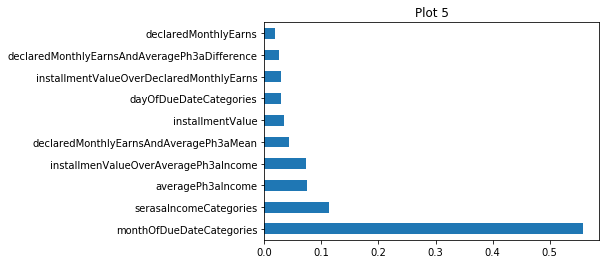

In [54]:
# feature_selection_group = dataframe[['declaredMonthlyEarns', 'installmentValue', 'serasaIncomeCategories', 'installmentValueOverDeclaredMonthlyEarns', 'dayOfDueDateCategories', 'averagePh3aIncome', 'installmenValueOverAveragePh3aIncome']]   
target = dataframe['booleanInstallmentStatus']
# feature_importances = get_feature_importances(feature_selection_group, target)
# plot_feature_importances(feature_importances)

x = feature_selection_group
y = dataframe['booleanInstallmentStatus']

model = ExtraTreesClassifier(max_depth = 5)
model.fit(x,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
plot_feature_importances(feat_importances, 'Plot 5')
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

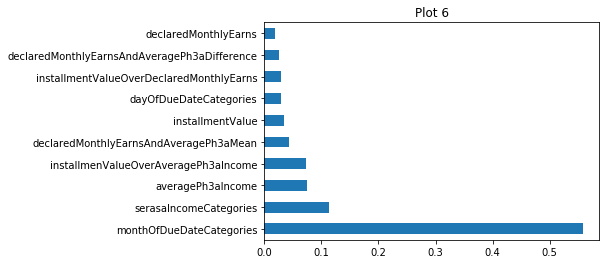

In [55]:
# feature_selection_group = dataframe[['declaredMonthlyEarns', 'installmentValue', 'serasaIncomeCategories', 'installmentValueOverDeclaredMonthlyEarns', 'dayOfDueDateCategories', 'averagePh3aIncome', 'installmenValueOverAveragePh3aIncome']]   
ph3aIncome_not_null = feature_selection_group['averagePh3aIncome'] != -1


# filtered_feature_selection_group = feature_selection_group[ph3aIncome_not_null]
# feature_importances_not_null = get_feature_importances(filtered_feature_selection_group, dataframe[ph3aIncome_not_null]['booleanInstallmentStatus'])
# plot_feature_importances(feature_importances_not_null)

x = feature_selection_group[ph3aIncome_not_null]
y = dataframe[ph3aIncome_not_null]['booleanInstallmentStatus']

# model = ExtraTreesClassifier(max_depth = 5)
model.fit(x,y)
feature_importances = pd.Series(model.feature_importances_, index=x.columns)
plot_feature_importances(feature_importances, 'Plot 6')

# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()


In [56]:
feature_selection_group[ph3aIncome_not_null].count()

declaredMonthlyEarns                            51
installmentValue                                51
serasaIncomeCategories                          51
installmentValueOverDeclaredMonthlyEarns        51
dayOfDueDateCategories                          51
monthOfDueDateCategories                        51
averagePh3aIncome                               51
installmenValueOverAveragePh3aIncome            51
declaredMonthlyEarnsAndAveragePh3aMean          51
declaredMonthlyEarnsAndAveragePh3aDifference    51
dtype: int64

D:\Programs and Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
D:\Programs and Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.09026042 0.07596726 0.         0.031875   0.0140625  0.4240625
 0.16901042 0.053125   0.00700549 0.13463141]


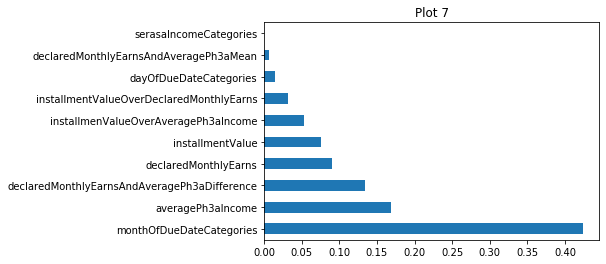

In [57]:
# feature_selection_group = dataframe[['declaredMonthlyEarns', 'installmentValue', 'serasaIncomeCategories', 'installmentValueOverDeclaredMonthlyEarns', 'dayOfDueDateCategories', 'averagePh3aIncome', 'installmenValueOverAveragePh3aIncome']]   
serasa_not_null = feature_selection_group['serasaIncomeCategories'] != -1
filtered_feature_selection_group = feature_selection_group[serasa_not_null]

# feature_importances = get_feature_importances(filtered_feature_selection_group, dataframe[serasa_not_null]['booleanInstallmentStatus'])
# plot_feature_importances(feature_importances)

x = filtered_feature_selection_group[serasa_not_null]
y = dataframe[serasa_not_null]['booleanInstallmentStatus']

model = ExtraTreesClassifier(max_depth = 5)
model.fit(x,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
plot_feature_importances(feat_importances, 'Plot 7')
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

In [58]:
feature_selection_group[serasa_not_null].count()

declaredMonthlyEarns                            17
installmentValue                                17
serasaIncomeCategories                          17
installmentValueOverDeclaredMonthlyEarns        17
dayOfDueDateCategories                          17
monthOfDueDateCategories                        17
averagePh3aIncome                               17
installmenValueOverAveragePh3aIncome            17
declaredMonthlyEarnsAndAveragePh3aMean          17
declaredMonthlyEarnsAndAveragePh3aDifference    17
dtype: int64

In [59]:
filtered_feature_selection_group

declaredMonthlyEarns  installmentValue  serasaIncomeCategories  \
0                 3000.0            258.56                       0   
1                 2500.0            556.26                       5   
2                 1800.0            497.77                       2   
3                 1500.0           1157.55                       6   
4                 1500.0            501.57                       3   
5                 8000.0            796.94                       4   
8                 3200.0            323.20                       3   
12                   0.0           1157.72                       5   
13                3060.0           1155.28                       5   
15                4000.0            178.61                       0   
18                2700.0            637.50                       1   
19                2500.0            497.77                       2   
21                   0.0           1157.72                       0   
23                3400.0            620.53                       0   
27                3000.0           1444.70                       0   
28                3000.0            679.99                       1   
42                6000.0            924.58                       4   

    installmentValueOverDeclaredMonthlyEarns  dayOfDueDateCategories  \
0                                   0.086187                       1   
1                                   0.222504                       1   
2                                   0.276539                       1   
3                                   0.771700                       0   
4                                   0.334380                       1   
5                                   0.099617                       1   
8                                   0.010100                       1   
12                                 -1.000000                       0   
13                                  0.377542                       0   
15                                  0.044652                       1   
18                                  0.023611                       1   
19                                  0.199108                       0   
21                                 -1.000000                       0   
23                                  0.182509                       0   
27                                  0.048157                       0   
28                                  0.226663                       1   
42                                  0.154097                       0   

    monthOfDueDateCategories  averagePh3aIncome  \
0                          3            812.495   
1                          3           3250.995   
2                          3           1250.995   
3                          4           8500.995   
4                          3           3750.995   
5                          3           3750.995   
8                          3           7500.995   
12                         4           4250.995   
13                         3           2750.995   
15                         3           1250.995   
18                         3           2250.995   
19                         3           4750.995   
21                         4           4250.995   
23                         3           2250.995   
27                         3           1750.995   
28                         3           3250.995   
42                         1          12500.995   

    installmenValueOverAveragePh3aIncome  \
0                               0.318230   
1                               0.171105   
2                               0.397899   
3                               0.136166   
4                               0.133717   
5                               0.212461   
8                               0.043088   
12                              0.272341   
13                              0.419950   
15                              0.142774   
18                              0.283208   

D:\Programs and Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.06943734 0.07269768 0.04629636 0.24648526 0.38390348 0.11258357
 0.06859632]


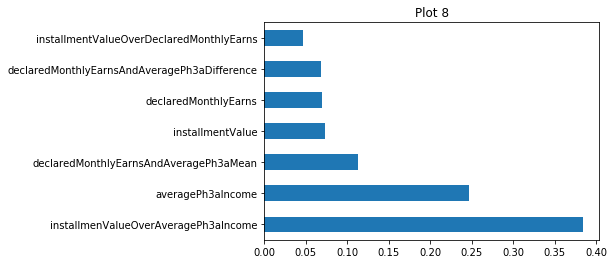

In [63]:
value_feature_selection_group = dataframe[['declaredMonthlyEarns', 'installmentValue', 'installmentValueOverDeclaredMonthlyEarns', 'averagePh3aIncome', 'installmenValueOverAveragePh3aIncome', 'declaredMonthlyEarnsAndAveragePh3aMean', 'declaredMonthlyEarnsAndAveragePh3aDifference']]   


# feature_importances = get_feature_importances(value_feature_selection_group, dataframe['booleanInstallmentStatus'])
# plot_feature_importances(feature_importances)

x = value_feature_selection_group
y = dataframe['booleanInstallmentStatus']

model = ExtraTreesClassifier(max_depth = 5)
model.fit(x,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
plot_feature_importances(feat_importances, 'Plot 8')


D:\Programs and Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.02073585 0.03770412 0.04215846 0.05599829 0.84340328]


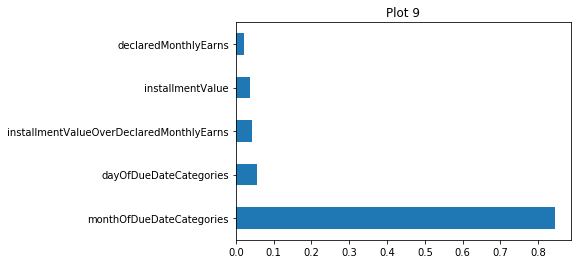

In [62]:
# features that doesn't have null values
not_null_feature_selection_group = dataframe[['declaredMonthlyEarns', 'installmentValue', 'installmentValueOverDeclaredMonthlyEarns', 'dayOfDueDateCategories', 'monthOfDueDateCategories']]   


# feature_importances = get_feature_importances(value_feature_selection_group, dataframe['booleanInstallmentStatus'])
# plot_feature_importances(feature_importances)

x = not_null_feature_selection_group
y = dataframe['booleanInstallmentStatus']

model = ExtraTreesClassifier(max_depth = 5)
model.fit(x,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
plot_feature_importances(feat_importances, 'Plot 9')

D:\Programs and Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.05180515 0.62634388 0.32185097]


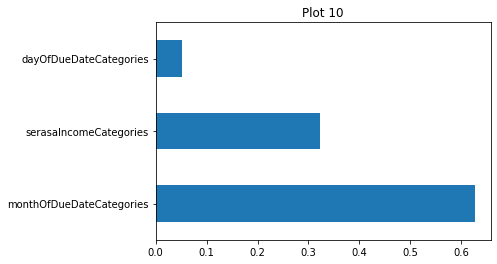

In [52]:
# Categorical features
category_feature_selection_group = dataframe[['dayOfDueDateCategories', 'monthOfDueDateCategories', 'serasaIncomeCategories']]   


# feature_importances = get_feature_importances(value_feature_selection_group, dataframe['booleanInstallmentStatus'])
# plot_feature_importances(feature_importances)

x = category_feature_selection_group
y = dataframe['booleanInstallmentStatus']

model = ExtraTreesClassifier(max_depth = 5)
model.fit(x,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
plot_feature_importances(feat_importances, 'Plot 10')